In [1]:
#%%
print('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/nn_model_script_emb_test.py - starting')

from array import array
from cmath import nan
from pyexpat import model
import statistics
from tkinter.ttk import Separator
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchviz import make_dot
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
from torchvision import datasets, transforms
from torch.autograd import variable
from itertools import chain
from sklearn import metrics as met
import pickle
from icecream import ic
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score

import matplotlib.pyplot as plt
import pathlib
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from importlib import reload
# import util
# import model_torch_simple
# from torchmetrics import Accuracy
from tqdm import tqdm
import argparse
from icecream import ic
import numpy as np
from PIL import Image
device = 'cuda' if torch.cuda.is_available() else 'cpu'

import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
#%%
seed = 42
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)

# train_data = np.loadtxt('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_emb/aa_data_train_gene.csv', delimiter = ',')
# train_target = pd.read_csv('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_emb/mic_aa_train_hml.csv')
# train_target = train_target[['EMB_MIC']]
# # don't touch test data, split out validation data from training data during training
# # test_data = np.loadtxt('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_EMB/aa_data_test_pca4k.csv', delimiter = ',')
# test_data = np.loadtxt('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_emb/aa_data_test_gene.csv', delimiter = ',')
# test_target = pd.read_csv('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_emb/mic_aa_test_hml.csv')
# test_target = test_target[['EMB_MIC']]

# all_data = np.concatenate((train_data, test_data), axis=0)
# all_target = pd.concat((train_target, test_target), axis=0)

# train_data, test_data, train_target, test_target = train_test_split(all_data, all_target, test_size=0.2, random_state=42, stratify=all_target)

/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/nn_model_script_emb_test.py - starting


In [2]:
def data_split(aa_array, encoded_mic):
    # Encode the target variable
    # Perform stratified train-test split
    train_data, test_data, train_target, test_target = train_test_split(
        aa_array,
        encoded_mic,
        test_size=0.1,  # 10% for testing
        stratify=encoded_mic,  # Ensures the proportion of each class is preserved
        random_state=42  # For reproducibility
    )
    return train_data, test_data, train_target, test_target
def is_within_doubling_dilution(pred, target, target_min, target_max):
    _ = np.arange(target_min-1, target_max+2, 1)
    index = [i for i, x in enumerate(_) if x == target][0]
    return (_[index-1] <= pred <= _[index+1])
def data_prep_(cryptic, gene_list, dr_list):
    # overlap = set(variants['sample_id']).intersection(set(cryptic['ENA_RUN'].to_list()))
    # variants = variants[variants['drugs'].isin(['ethambutol'])]
    # variants = variants[variants['sample_id'].isin(overlap)]
    # variants['SNP'] = variants['gene'] + '-'+ variants['change']
    variants = pd.read_csv('../variants_full.csv')
    variants = variants[variants['gene'] != 'PPE35']
    variants = variants[variants['type'] != 'synonymous_variant']
    variants = variants[variants['type'] != 'non_coding_transcript_exon_variant']
    overlap = variants[~variants['sample_id'].isin(cryptic['ENA_RUN'])]
    overlap = overlap['sample_id'].unique()
    print(overlap)
    print(overlap.shape)
    # variants = variants[variants['drugs'].isin(['ethambutol'])]
    variants = variants[variants['gene'].isin(gene_list)]
    variants = variants[variants['sample_id'].isin(overlap)]
    variants['SNP'] = variants['gene'] + '-'+ variants['change']
    crypticSNPnames = np.load('crypticSNPnames.npy', allow_pickle=True)
    variants = variants[variants['SNP'].isin(crypticSNPnames)]
    # print(variants.shape)
    # print(variants['sample_id'].unique().shape)
    def compare_snp_lists_with_values_optimized(set_list, query_list, values_list):
        # Create a dictionary from query_list and values_list for direct mapping
        query_dict = dict(zip(query_list, values_list))
        # Use list comprehension to build the output list directly
        output_list = [query_dict.get(snp, 0) for snp in set_list]
        return output_list
    # Example usage
    # set_list = ['SNP1', 'SNP2', 'SNP3', 'SNP4']
    # query_list = ['SNP2', 'SNP4']
    # values_list = [5, 10]  # Corresponding values for 'SNP2' and 'SNP4'
    # output_list = compare_snp_lists_with_values_optimized(set_list, query_list, values_list)
    # print(output_list)  # Expected output: [0, 5, 0, 10]# Getting all snp data
    aa = []
    dr = []
    all_snp = variants['SNP'].unique() # here is a list of all snps values title for the row in the final table
    for x in tqdm(overlap):
    # for x in tqdm(variants['sample_id'].unique()):
        if x in variants['sample_id'].tolist():
            aa.append(compare_snp_lists_with_values_optimized(all_snp, variants[variants['sample_id']==x]['SNP'].to_list(), variants[variants['sample_id']==x]['freq'].to_list()))
            if dr_list[0] in variants[variants['sample_id']==x]['drugs'].unique():
                dr.append(1)
            else:
                dr.append(0)
        else:
            # aa.append([0]*len(all_snp))
            pass
        # print('SNP')
    aa_array = np.array(aa)
    aa_array[aa_array < 0.8] = 0
    aa_array[aa_array >= 0.8] = 1
    # mic_aa = cryptic[cryptic['ENA_RUN'].isin(overlap)]#.iloc[:,14:27]
    # # mic_aa = cryptic[cryptic['ENA_RUN'].isin(variants['sample_id'].unique())]#.iloc[:,14:27]
    # # print(mic_aa.shape)
    # # mic_aa['wgs_id'] = pd.Categorical(mic_aa['ENA_RUN'], categories=variants['sample_id'].unique().tolist(), ordered=True)
    # # mic_aa = mic_aa.sort_values('ENA_RUN')
    # mic_aa.ENA_RUN = mic_aa.ENA_RUN.astype('category')
    # mic_aa.ENA_RUN = mic_aa.ENA_RUN.cat.set_categories(overlap)
    # # mic_aa.ENA_RUN = mic_aa.ENA_RUN.cat.set_categories(variants['sample_id'].unique().tolist())
    # mic_aa = mic_aa.sort_values([“ENA_RUN”])  ## 'sort' changed to 'sort_values'
    # # print(mic_aa.shape)return aa_array, dr#, mic_aa
    return aa_array, dr

## Data

In [3]:
def is_within_doubling_dilution(pred, target, target_min, target_max):
    _ = np.arange(target_min-1, target_max+2, 1)
    index = [i for i, x in enumerate(_) if x == target][0]
    return (_[index-1] <= pred <= _[index+1])

In [4]:
drs = np.load('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/individual_models/all_sample_drs_cryptic_emb.npy')
snps = np.load('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/individual_models/all_sample_snps_cryptic_emb.npy')

drs = pd.DataFrame(drs)     
train_data, test_data, train_target, test_target = data_split(snps, drs)

In [5]:
cryptic_drs = np.load('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/individual_models/1473_sample_drs_cryptic_emb.npy')
cryptic_snps = np.load('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/individual_models/1473_snps_cryptic_emb.npy')

cryptic_drs = pd.DataFrame(cryptic_drs)

### resFeed

In [6]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

# def is_within_doubling_dilution(pred, target, target_min, target_max):
#     # Ensure target_min and target_max are scalars
#     target_min = target_min.item() if isinstance(target_min, np.ndarray) or isinstance(target_min, pd.Series) else target_min
#     target_max = target_max.item() if isinstance(target_max, np.ndarray) or isinstance(target_max, pd.Series) else target_max

#     # Create a range based on the scalar values of target_min and target_max
#     dilution_range = np.arange(target_min - 1, target_max + 2, 1)
    
#     # Find the index of the target value
#     index = np.where(dilution_range == target)[0][0]  # Use np.where to find the index
    
#     # Check if prediction is within the acceptable range
#     return dilution_range[index - 1] <= pred <= dilution_range[index + 1]

# Example usage
target_min, target_max = cryptic_drs.min().values, cryptic_drs.max()

# Load the data
cryptic_drs = np.load('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/individual_models/1473_sample_drs_cryptic_emb.npy')
cryptic_snps = np.load('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/individual_models/1473_snps_cryptic_emb.npy')

# Convert to pandas DataFrame
cryptic_drs = pd.DataFrame(cryptic_drs)

In [7]:


# Combine the features and target variable
data = cryptic_snps
target = cryptic_drs

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

# Create the XGBoost model
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

target_min, target_max = cryptic_drs.min().values, cryptic_drs.max().values

doubling_dilution_accuracy = np.mean([is_within_doubling_dilution(pred, true, target_min, target_max) for pred, true in zip(y_pred, y_test)])
print(f"Doubling Dilution Accuracy: {doubling_dilution_accuracy * 100:.2f}%")

#testing
cutoff = 4
test_target_bi = (np.squeeze(np.array(y_test)) >= cutoff).astype(int) #(target_mic_list  >= cutoff).astype(int)
test_predictions_bi = (np.squeeze(np.array(y_pred)) >= cutoff).astype(int)  #(np.array(pred_mic_list) >= cutoff).astype(int)

auc = roc_auc_score(test_target_bi, test_predictions_bi)
print("AUC:", auc)

# Calculate confusion matrix components
tn, fp, fn, tp = confusion_matrix(test_target_bi, test_predictions_bi).ravel()

# Calculate sensitivity (recall)
sensitivity = tp / (tp + fn)
print("Sensitivity:", sensitivity)

# Calculate specificity
specificity = tn / (tn + fp)
print("Specificity:", specificity)

Accuracy: 0.49758029036515616
Doubling Dilution Accuracy: 0.00%
AUC: 0.7993598298440237
Sensitivity: 0.6605263157894737
Specificity: 0.9381933438985737


#### Quick test with xgboost

In [12]:
cryptic_drs = np.load('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/individual_models/1473_sample_drs_cryptic_emb.npy')
cryptic_snps = np.load('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/individual_models/1473_snps_cryptic_emb.npy')

ValueError: Cannot load file containing pickled data when allow_pickle=False

In [11]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

# def is_within_doubling_dilution(pred, target, target_min, target_max):
#     # Ensure target_min and target_max are scalars
#     target_min = target_min.item() if isinstance(target_min, np.ndarray) or isinstance(target_min, pd.Series) else target_min
#     target_max = target_max.item() if isinstance(target_max, np.ndarray) or isinstance(target_max, pd.Series) else target_max

#     # Create a range based on the scalar values of target_min and target_max
#     dilution_range = np.arange(target_min - 1, target_max + 2, 1)
    
#     # Find the index of the target value
#     index = np.where(dilution_range == target)[0][0]  # Use np.where to find the index
    
#     # Check if prediction is within the acceptable range
#     return dilution_range[index - 1] <= pred <= dilution_range[index + 1]

# Example usage
target_min, target_max = cryptic_drs.min().values, cryptic_drs.max()

# Load the data
cryptic_drs = np.load('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/individual_models/1473_sample_drs_cryptic_emb.npy')
cryptic_snps = np.load('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/individual_models/1473_snps_cryptic_emb.npy')

# Convert to pandas DataFrame
cryptic_drs = pd.DataFrame(cryptic_drs)

# Combine the features and target variable
data = cryptic_snps
target = cryptic_drs

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

# Create the XGBoost model
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

target_min, target_max = cryptic_drs.min(), cryptic_drs.max() 

doubling_dilution_accuracy = np.mean([is_within_doubling_dilution(pred, true, target_min, target_max) for pred, true in zip(y_pred, y_test)])
print(f"Doubling Dilution Accuracy: {doubling_dilution_accuracy * 100:.2f}%")

#testing
cutoff = 4
test_target_bi = (np.squeeze(np.array(y_test)) >= cutoff).astype(int) #(target_mic_list  >= cutoff).astype(int)
test_predictions_bi = (np.squeeze(np.array(y_pred)) >= cutoff).astype(int)  #(np.array(pred_mic_list) >= cutoff).astype(int)

auc = roc_auc_score(test_target_bi, test_predictions_bi)
print("AUC:", auc)

# Calculate confusion matrix components
tn, fp, fn, tp = confusion_matrix(test_target_bi, test_predictions_bi).ravel()

# Calculate sensitivity (recall)
sensitivity = tp / (tp + fn)
print("Sensitivity:", sensitivity)

# Calculate specificity
specificity = tn / (tn + fp)
print("Specificity:", specificity)

AttributeError: 'numpy.float64' object has no attribute 'values'

In [7]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

# def is_within_doubling_dilution(pred, target, target_min, target_max):
#     # Ensure target_min and target_max are scalars
#     target_min = target_min.item() if isinstance(target_min, np.ndarray) or isinstance(target_min, pd.Series) else target_min
#     target_max = target_max.item() if isinstance(target_max, np.ndarray) or isinstance(target_max, pd.Series) else target_max

#     # Create a range based on the scalar values of target_min and target_max
#     dilution_range = np.arange(target_min - 1, target_max + 2, 1)
    
#     # Find the index of the target value
#     index = np.where(dilution_range == target)[0][0]  # Use np.where to find the index
    
#     # Check if prediction is within the acceptable range
#     return dilution_range[index - 1] <= pred <= dilution_range[index + 1]

# Example usage
target_min, target_max = cryptic_drs.min().values, cryptic_drs.max()

# Load the data
cryptic_drs = np.load('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/individual_models/1473_sample_drs_cryptic_emb.npy')
cryptic_snps = np.load('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/individual_models/1473_snps_cryptic_emb.npy')

# Convert to pandas DataFrame
cryptic_drs = pd.DataFrame(cryptic_drs)

# Combine the features and target variable
data = cryptic_snps
target = cryptic_drs

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

# Create the XGBoost model
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

target_min, target_max = cryptic_drs.min().values, cryptic_drs.max().values

doubling_dilution_accuracy = np.mean([is_within_doubling_dilution(pred, true, target_min, target_max) for pred, true in zip(y_pred, y_test)])
print(f"Doubling Dilution Accuracy: {doubling_dilution_accuracy * 100:.2f}%")

#testing
cutoff = 4
test_target_bi = (np.squeeze(np.array(y_test)) >= cutoff).astype(int) #(target_mic_list  >= cutoff).astype(int)
test_predictions_bi = (np.squeeze(np.array(y_pred)) >= cutoff).astype(int)  #(np.array(pred_mic_list) >= cutoff).astype(int)

auc = roc_auc_score(test_target_bi, test_predictions_bi)
print("AUC:", auc)

# Calculate confusion matrix components
tn, fp, fn, tp = confusion_matrix(test_target_bi, test_predictions_bi).ravel()

# Calculate sensitivity (recall)
sensitivity = tp / (tp + fn)
print("Sensitivity:", sensitivity)

# Calculate specificity
specificity = tn / (tn + fp)
print("Specificity:", specificity)

Accuracy: 0.4958205015398152
Doubling Dilution Accuracy: 100.00%
AUC: 0.8141102237657637
Sensitivity: 0.6885245901639344
Specificity: 0.9396958573675931


#### over/undersampling

In [40]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter

# Assuming your data is in a DataFrame called df, with 'outcome' as the target column
# Split features (X) and target (y)
X = cryptic_snps
y = cryptic_drs

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ensure that y_train is passed as a 1D array for resampling
y_train = y_train.squeeze()  # Convert y_train to a Series (1D array) for compatibility with imblearn

# Check class distribution
counter = Counter(y_train)
print(f"Class distribution before resampling: {counter}")

# Define oversampling strategy: Oversample minority classes to match the majority class
over = RandomOverSampler(sampling_strategy='auto' )

# Define undersampling strategy: Undersample the majority class to achieve balance
under = RandomUnderSampler(sampling_strategy={key: min(counter.values()) for key in counter})

# Create a pipeline for both oversampling and undersampling
pipeline = Pipeline(steps=[('o', over), ('u', under)])

# Apply oversampling and undersampling to the training data
X_resampled, y_resampled = pipeline.fit_resample(X_train, y_train)

# Checking the new class distribution
print("Class distribution after resampling:", Counter(y_resampled))

# Convert y_resampled back to a DataFrame with one column (if needed)
# y_resampled = pd.DataFrame(y_resampled, columns=['outcome'])

# You can now proceed with model training on X_resampled, y_resampled

Class distribution before resampling: Counter({1.0: 3173, 2.0: 2378, 3.0: 1206, 4.0: 1086, 0.0: 871, 5.0: 375})
Class distribution after resampling: Counter({0.0: 375, 1.0: 375, 2.0: 375, 3.0: 375, 4.0: 375, 5.0: 375})


In [43]:

# Convert to pandas DataFrame
cryptic_drs = pd.DataFrame(cryptic_drs)

# Combine the features and target variable

# Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)
X_train, y_train= X_resampled, y_resampled
# Create the XGBoost model
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

target_min, target_max = cryptic_drs.min().values, cryptic_drs.max().values

doubling_dilution_accuracy = np.mean([is_within_doubling_dilution(pred, true, target_min, target_max) for pred, true in zip(y_pred, y_test)])
print(f"Doubling Dilution Accuracy: {doubling_dilution_accuracy * 100:.2f}%")

#testing
cutoff = 4
test_target_bi = (np.squeeze(np.array(y_test)) >= cutoff).astype(int) #(target_mic_list  >= cutoff).astype(int)
test_predictions_bi = (np.squeeze(np.array(y_pred)) >= cutoff).astype(int)  #(np.array(pred_mic_list) >= cutoff).astype(int)

auc = roc_auc_score(test_target_bi, test_predictions_bi)
print("AUC:", auc)

# Calculate confusion matrix components
tn, fp, fn, tp = confusion_matrix(test_target_bi, test_predictions_bi).ravel()

# Calculate sensitivity (recall)
sensitivity = tp / (tp + fn)
print("Sensitivity:", sensitivity)

# Calculate specificity
specificity = tn / (tn + fp)
print("Specificity:", specificity)

Accuracy: 0.3915530136383634
Doubling Dilution Accuracy: 0.00%
AUC: 0.8049198953524691
Sensitivity: 0.674863387978142
Specificity: 0.934976402726796


## dataloader

In [8]:
def is_within_doubling_dilution(pred, target, target_min, target_max):
    _ = np.arange(target_min-1, target_max+2, 1)
    index = [i for i, x in enumerate(_) if x == target][0]
    return (_[index-1] <= pred <= _[index+1])

In [9]:
from torch.utils.data import Subset
from collections import Counter

N_samples = train_data.shape[0]
DRUGS = train_target.columns
# LOCI = train_data.columns
assert set(DRUGS) == set(train_target.columns)
N_drugs = len(DRUGS)
#%%
def my_padding(seq_tuple):
    list_x_ = list(seq_tuple)
    max_len = len(max(list_x_, key=len))
    for i, x in enumerate(list_x_):
        list_x_[i] = x + "N"*(max_len-len(x))
    return list_x_

#! faster than my_padding try to incorporate
def collate_padded_batch(batch):
    # get max length of seqs in batch
    max_len = max([x[0].shape[1] for x in batch])
    return torch.utils.data.default_collate(
        [(F.pad(x[0], (0, max_len - x[0].shape[1])), x[1]) for x in batch] #how does F.pad work
    )


class Dataset(torch.utils.data.Dataset): #? what's the difference between using inheritance and not?
    def __init__(
        self,
        seq_df,
        res_df,
        # target_loci=LOCI,
        target_drugs=DRUGS,
        one_hot_dtype=torch.int8,
        transform=None,
    ):
        self.transform = transform
        # self.seq_df = seq_df[target_loci]
        self.seq_df = seq_df
        self.res_df = res_df[target_drugs]
        # if not self.seq_df.index.equals(self.res_df.index):
        #     raise ValueError(
        #         "Indices of sequence and resistance dataframes don't match up"
        #     )
        self.one_hot_dtype = one_hot_dtype

    def __getitem__(self, index):
        """
        numerical index --> get `index`-th sample
        string index --> get sample with name `index`
        """
        index = int(index)
        if isinstance(index, int):
            seqs_comb = self.seq_df[index]
            mic = self.res_df.iloc[index, 0]
            # res = self.res_df.iloc[index, 1]
        elif isinstance(index, str):
            seqs_comb = self.seq_df[int(index)]
            mic = self.res_df.iloc[index, 0]
            # res = self.res_df.iloc[index, 1]
        else:
            raise ValueError(
                "Index needs to be an integer or a sample name present in the dataset"
            )

        if self.transform:
            res = np.log(res)
            
            # self.res_mean = self.res_df.mean()
            # self.res_std = self.res_df.std()
            # res = (res - self.res_mean) / self.res_std
            # res = self.transform(res)
        return torch.unsqueeze(torch.tensor(seqs_comb).float(), 0),  torch.tensor(mic).long().flatten().squeeze()
    def __len__(self):
        return self.res_df.shape[0]

train_dataset = Dataset(train_data, train_target, one_hot_dtype=torch.float, transform=False)
val_dataset = Dataset(test_data, test_target, one_hot_dtype=torch.float, transform=False)
cryptic_dataset = Dataset(cryptic_snps, cryptic_drs, one_hot_dtype=torch.float, transform=False)

# train_dataset, val_dataset = random_split(training_dataset, [int(len(training_dataset)*0.9), len(training_dataset)-int(len(training_dataset)*0.9)])

# train_idx, validation_idx = train_test_split(np.arange(len(train_data)),
#                                              test_size=0.1,
#                                              random_state=42,
#                                              shuffle=True,
#                                              stratify=train_target)
train_idx, validation_idx = train_test_split(np.arange(len(cryptic_drs)),
                                            test_size=0.2,
                                            random_state=42,
                                            shuffle=True,
                                            stratify=cryptic_drs)

# Subset dataset for train and val
train_dataset_cryptic = Subset(cryptic_dataset, train_idx)
test_dataset_cryptic = Subset(cryptic_dataset, validation_idx)    


# # Subset dataset for train and val
# train_dataset = Subset(training_dataset, train_idx)
# val_dataset = Subset(training_dataset, validation_idx)

# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# # device = 'cpu'

y_true = train_target
# y_true = pd.concat([train_target, test_target])

column_weight_maps = {}

for column in y_true.columns:
    column_values = y_true[column].dropna().values
    values, counts = np.unique(column_values, return_counts=True)
    frequency = counts / len(column_values)
    
    # Calculate weights as the inverse of frequencies
    weights_inverse = 1/frequency
    # weights_inverse = 1 - frequency
    
    # Normalize weights to ensure they sum up to 1
    weights_normalized = weights_inverse / np.sum(weights_inverse)
    
    # Map each MIC value to its corresponding weight
    weight_map = {value: weight for value, weight in zip(values, weights_normalized)}
    
    column_weight_maps[column] = weight_map

def get_weighted_masked_cross_entropy_loss(column_weight_maps):
    """
    Creates a loss function that computes a weighted cross entropy loss, taking into account class imbalances.
    :param column_weight_maps: Dictionary mapping column names to their corresponding class weight maps.
    """
    def weighted_masked_cross_entropy_loss(y_pred, y_true):
        # weighted_losses = torch.Tensor().to(device)
        weighted_losses = []
        col_weight_map = column_weight_maps
        # print(col_weight_map)
        mean_weight = np.mean(list(col_weight_map.values())) # just in case if a number is not recognised and the loss doesn't go crazy

        # print(y_pred.size())
        # Assuming y_true is a tensor of class indices for each column and y_pred are the logits
        weights_col = [col_weight_map.get(y.item(), mean_weight) for y in y_true]
        # print(weights_col)
        # CrossEntropyLoss expects class indices as y_true, and logits as y_pred
        loss_fn = F.cross_entropy
        col_loss = loss_fn(y_pred, y_true, reduction = 'none').to(device)
        
        # loss_fn = nn.CrossEntropyLoss(reduction = 'none')
        # col_loss = loss_fn(y_pred, y_true)
        # print(y_true.dtype)
        # print(col_loss)
        weights_col = torch.Tensor(weights_col).to(device)
        # print(weights_col)
        # print(col_loss)
        weighted_col_loss = weights_col * col_loss
        # print(weighted_col_loss)
        weighted_losses.append(weighted_col_loss.mean())

        total_weighted_loss = torch.stack(weighted_losses).mean()
        
        # for i, column in enumerate(column_weight_maps.keys()):
        #     col_weight_map = column_weight_maps[column]
        #     print(y_pred.size())
        #     # Assuming y_true is a tensor of class indices for each column and y_pred are the logits
        #     weights_col = torch.tensor([col_weight_map[y.item()] for y in y_true[:, i]], dtype=torch.float32, device=y_true.device)
        #     print(weights_col)
        #     # CrossEntropyLoss expects class indices as y_true, and logits as y_pred
        #     loss_fn = torch.nn.CrossEntropyLoss(reduction='none')
        #     col_loss = loss_fn(y_pred[:, i,], y_true[:, i])
            
        #     weighted_col_loss = weights_col * col_loss
        #     weighted_losses.append(weighted_col_loss.mean())
        
        # total_weighted_loss = torch.stack(weighted_losses).mean()
        return total_weighted_loss

    return weighted_masked_cross_entropy_loss

# Also assuming `columns` is a list of your target column names corresponding to y_true and y_pred
weighted_cross_entropy_loss_fn_mic = get_weighted_masked_cross_entropy_loss(column_weight_maps[0])
# weighted_cross_entropy_loss_fn_bi = get_weighted_masked_cross_entropy_loss(column_weight_maps['EMB_MIC_y'])
# loss = weighted_cross_entropy_loss_fn(y_true_tensor, y_pred_logits, columns)

def save_to_file(file_path, appendix, epoch, lr, cnndr, fcdr, l2, train_loss, test_loss, optimizer, model):
    train_loss = [float(arr) for arr in train_loss]
    test_loss = [float(arr) for arr in test_loss]
    with open(file_path, "a") as f:
        f.write(f"#>> {appendix}, Epoch: {epoch}, LR: {lr}, fcDR: {fcdr}\n")
        f.write(f"Train_Loss= {train_loss}\n")
        f.write(f"Test_Loss= {test_loss}\n")
        f.write(f"lossGraph(Train_Loss, Test_Loss, '{appendix}-Epoch-{epoch}-LR-{lr}-fcDR-{fcdr}')\n")

    torch.save({
        'optimizer': optimizer.state_dict(),
        'model': model.state_dict(),
    }, f'/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/saved_models/seq-{appendix}-{epoch}-{lr}-{cnndr}-{fcdr}-{l2}.pth')

## model

In [11]:
# Define the autoencoder class

class Autoencoder(nn.Module):
    def __init__(self, input_size, dropout=0.5):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 5000),
            nn.ReLU(),
            nn.Linear(5000, 2000) ,
            nn.Dropout(dropout),    
            nn.ReLU(),
            nn.Linear(2000, 500),
            nn.Dropout(dropout),    
            nn.ReLU(),
            nn.Linear(500, 100),
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(100, 500),
            nn.ReLU(),   
            nn.Linear(500, 2000),
            nn.Dropout(dropout),    
            nn.ReLU(),
            nn.Linear(2000, 5000),
            nn.Dropout(dropout),    
            nn.ReLU(),
            nn.Linear(5000, input_size),
            nn.Sigmoid()  # Use Sigmoid since input is binary
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
def add_noise(inputs, noise_factor=0.3):
    noisy = inputs + noise_factor * torch.randn_like(inputs)
    noisy = torch.clamp(noisy, 0., 1.)  # Ensure values stay within [0, 1]
    return noisy    
# criterion = F.cross_entropy
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=8)

## Parameter search

Epoch [10/100], Train Loss: 0.0010, Val Loss: 0.0011
Epoch [20/100], Train Loss: 0.0004, Val Loss: 0.0006
Epoch [30/100], Train Loss: 0.0002, Val Loss: 0.0005
Epoch [40/100], Train Loss: 0.0002, Val Loss: 0.0002
Epoch [50/100], Train Loss: 0.0001, Val Loss: 0.0007
Epoch [60/100], Train Loss: 0.0001, Val Loss: 0.0005
Epoch [70/100], Train Loss: 0.0001, Val Loss: 0.0005
Epoch [80/100], Train Loss: 0.0001, Val Loss: 0.0013
Epoch [90/100], Train Loss: 0.0001, Val Loss: 0.0004
Epoch [100/100], Train Loss: 0.0001, Val Loss: 0.0004


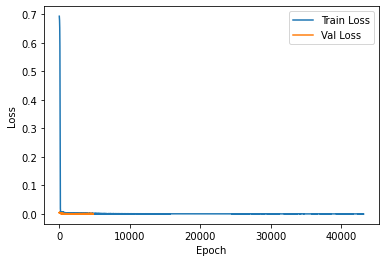

Training complete.
Accuracy: 48.73%

Classification Report:

              precision    recall  f1-score   support

           0       0.15      0.02      0.03       199
           1       0.49      0.90      0.64       714
           2       0.46      0.13      0.20       534
           3       0.48      0.46      0.47       271
           4       0.47      0.54      0.51       244
           5       0.68      0.35      0.46        86

    accuracy                           0.49      2048
   macro avg       0.46      0.40      0.38      2048
weighted avg       0.45      0.49      0.42      2048

Doubling Dilution Accuracy: 92.19%
AUC: 0.780167213461742
Sensitivity: 0.6272727272727273
Specificity: 0.9330616996507567
XGBoost Accuracy: 49.07%

XGBoost Classification Report:

              precision    recall  f1-score   support

           0       0.30      0.03      0.05       199
           1       0.50      0.89      0.64       714
           2       0.47      0.13      0.20       534

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.profiler

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 256
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=8)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, num_workers=8, shuffle=True)
dropout = 0
noise_factor = 0
train_loader_cryptic = DataLoader(dataset=train_dataset_cryptic, batch_size=batch_size, num_workers=8, drop_last=True)
test_loader_cryptic = DataLoader(dataset=test_dataset_cryptic, batch_size=batch_size, num_workers=8, shuffle=True, drop_last=True) 
for lr in [1e-5]: 

    # with torch.profiler.profile(
    #     activities=[
    #         torch.profiler.ProfilerActivity.CPU,
    #         torch.profiler.ProfilerActivity.CUDA,
    #     ],
    #     record_shapes=True,
    #     with_stack=True
    # ) as prof:
        # Parameters
    input_size = 1473  # Adjust this based on your input vector length
    num_epochs = 100

    # Instantiate the model, define loss function and optimizer
    model = Autoencoder(input_size, dropout).to(device)  # Move model to GPU
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_loss = []
    val_loss = []

    # Training loop
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        for data, _ in train_loader:
            # print('new batch', data.shape)
            data = data.to(device)  # Move data to GPU
            noisy_data = add_noise(data, noise_factor)
            output = model(noisy_data)
            loss = criterion(output, data)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        
        # Validation phase
        model.eval()
        with torch.no_grad():  # Disable gradient computation during validation
            for data, _ in val_loader:
                data = data.to(device)  # Move data to GPU
                output = model(data)
                loss = criterion(output, data)
                val_loss.append(loss.item())
            
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss[-1]:.4f}, Val Loss: {val_loss[-1]:.4f}')

# prof.export_chrome_trace("torch_trace.json")
# Plot train loss and val loss

    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Save the trained model
    torch.save(model.state_dict(), 'autoencoder.pth')

    print('Training complete.')


    compressed_data = []
    labels = []

    test_compressed_data = []
    test_labels = []

    with torch.no_grad():
        for data, label in train_loader_cryptic:
            data = data.to(device)  # Move data to GPU
            compressed = model.encoder(data)
            compressed_data.append(compressed.cpu().numpy())
            labels.append(label.numpy())
            
        for data, label in test_loader_cryptic:
            data = data.to(device)  # Move data to GPU
            compressed = model.encoder(data)
            test_compressed_data.append(compressed.cpu().numpy())
            test_labels.append(label.numpy())

    compressed_data = np.vstack(compressed_data)
    compressed_data = compressed_data.squeeze(axis=1)
    labels = np.hstack(labels)

    test_compressed_data = np.vstack(test_compressed_data)
    test_compressed_data = test_compressed_data.squeeze(axis=1)
    test_labels = np.hstack(test_labels)

        
    from sklearn.neural_network import MLPClassifier
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import classification_report, accuracy_score
    from xgboost import XGBClassifier

    # Split the compressed data into training and testing sets
    X_train, X_test, y_train, y_test = compressed_data, test_compressed_data, labels, test_labels
#MLP
    # Initialize and train the MLP classifier
    mlp = MLPClassifier(hidden_layer_sizes=(500, 500,100, 100, 50, 50), max_iter=500, random_state=42)
    mlp.fit(X_train, y_train)

    # Predict using the trained MLP
    y_pred = mlp.predict(X_test)

    # Evaluate the performance
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred))
    
    target_min, target_max = labels.min(), labels.max()

    doubling_dilution_accuracy = np.mean([is_within_doubling_dilution(pred, true, target_min, target_max) for pred, true in zip(y_pred, y_test)])
    print(f"Doubling Dilution Accuracy: {doubling_dilution_accuracy * 100:.2f}%")
    
    #testing
    cutoff = 4
    test_target_bi = (np.squeeze(np.array(y_test)) >= cutoff).astype(int) #(target_mic_list  >= cutoff).astype(int)
    test_predictions_bi = (np.squeeze(np.array( y_pred)) >= cutoff).astype(int)  #(np.array(pred_mic_list) >= cutoff).astype(int)

    auc = roc_auc_score(test_target_bi, test_predictions_bi)
    print("AUC:", auc)

    # Calculate confusion matrix components
    tn, fp, fn, tp = confusion_matrix(test_target_bi, test_predictions_bi).ravel()

    # Calculate sensitivity (recall)
    sensitivity = tp / (tp + fn)
    print("Sensitivity:", sensitivity)

    # Calculate specificity
    specificity = tn / (tn + fp)
    print("Specificity:", specificity)

#XGB
    # Initialize and train the XGBoost classifier
    xgb_model = XGBClassifier()
    xgb_model.fit(X_train, y_train)

    # Predict using the trained XGBoost model
    y_pred_xgb = xgb_model.predict(X_test)

    # Evaluate the performance
    accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
    print(f"XGBoost Accuracy: {accuracy_xgb * 100:.2f}%")
    print("\nXGBoost Classification Report:\n")
    print(classification_report(y_test, y_pred_xgb))
    
    doubling_dilution_accuracy = np.mean([is_within_doubling_dilution(pred, true, target_min, target_max) for pred, true in zip(y_pred_xgb, y_test)])
    print(f"Doubling Dilution Accuracy: {doubling_dilution_accuracy * 100:.2f}%")
    
    #testing
    cutoff = 4
    test_target_bi = (np.squeeze(np.array(y_test)) >= cutoff).astype(int) #(target_mic_list  >= cutoff).astype(int)
    test_predictions_bi = (np.squeeze(np.array( y_pred_xgb)) >= cutoff).astype(int)  #(np.array(pred_mic_list) >= cutoff).astype(int)

    auc = roc_auc_score(test_target_bi, test_predictions_bi)
    print("AUC:", auc)

    # Calculate confusion matrix components
    tn, fp, fn, tp = confusion_matrix(test_target_bi, test_predictions_bi).ravel()

    # Calculate sensitivity (recall)
    sensitivity = tp / (tp + fn)
    print("Sensitivity:", sensitivity)

    # Calculate specificity
    specificity = tn / (tn + fp)
    print("Specificity:", specificity)

    

## MTL

### data

In [80]:
cryptic_drs = np.load('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/individual_models/1473_sample_drs_cryptic_emb.npy')
cryptic_snps = np.load('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/individual_models/1473_snps_cryptic_emb.npy')

cryptic_drs = pd.DataFrame(cryptic_drs)
cryptic_bi = pd.DataFrame(np.array([1 if x >= 4 else 0 for x in cryptic_drs.values]))

In [81]:
compressed_data = []

with torch.no_grad():
    for data, label in train_loader_cryptic:
        data = data.to(device)  # Move data to GPU
        compressed = model.encoder(data)
        compressed_data.append(compressed.cpu().numpy())
        labels.append(label.numpy())
                
    for data, label in test_loader_cryptic:
        data = data.to(device)  # Move data to GPU
        compressed = model.encoder(data)
        compressed_data.append(compressed.cpu().numpy())
        labels.append(label.numpy())

AttributeError: 'XGBClassifier' object has no attribute 'encoder'

In [78]:
mic_series_all = pd.merge(cryptic_drs, cryptic_bi, left_index=True, right_index=True)
train_data, test_data, train_target, test_target = data_split(cryptic_snps, mic_series_all)
target_min, target_max = cryptic_drs.min().values, cryptic_drs.max().values

### dataloader

In [ ]:
from torch.utils.data import Subset
from collections import Counter

N_samples = train_data.shape[0]
DRUGS = train_target.columns
# LOCI = train_data.columns
assert set(DRUGS) == set(train_target.columns)
N_drugs = len(DRUGS)
#%%
def my_padding(seq_tuple):
    list_x_ = list(seq_tuple)
    max_len = len(max(list_x_, key=len))
    for i, x in enumerate(list_x_):
        list_x_[i] = x + "N"*(max_len-len(x))
    return list_x_

#! faster than my_padding try to incorporate
def collate_padded_batch(batch):
    # get max length of seqs in batch
    max_len = max([x[0].shape[1] for x in batch])
    return torch.utils.data.default_collate(
        [(F.pad(x[0], (0, max_len - x[0].shape[1])), x[1]) for x in batch] #how does F.pad work
    )


class Dataset(torch.utils.data.Dataset): #? what's the difference between using inheritance and not?
    def __init__(
        self,
        seq_df,
        res_df,
        # target_loci=LOCI,
        target_drugs=DRUGS,
        one_hot_dtype=torch.int8,
        transform=None,
    ):
        self.transform = transform
        # self.seq_df = seq_df[target_loci]
        self.seq_df = seq_df
        self.res_df = res_df[target_drugs]
        # if not self.seq_df.index.equals(self.res_df.index):
        #     raise ValueError(
        #         "Indices of sequence and resistance dataframes don't match up"
        #     )
        self.one_hot_dtype = one_hot_dtype

    def __getitem__(self, index):
        """
        numerical index --> get `index`-th sample
        string index --> get sample with name `index`
        """
        index = int(index)
        if isinstance(index, int):
            seqs_comb = self.seq_df[index]
            mic = self.res_df.iloc[index, 0]
            res = self.res_df.iloc[index, 1]
        elif isinstance(index, str):
            seqs_comb = self.seq_df[int(index)]
            mic = self.res_df.iloc[index, 0]
            res = self.res_df.iloc[index, 1]
        else:
            raise ValueError(
                "Index needs to be an integer or a sample name present in the dataset"
            )

        if self.transform:
            res = np.log(res)
            
            # self.res_mean = self.res_df.mean()
            # self.res_std = self.res_df.std()
            # res = (res - self.res_mean) / self.res_std
            # res = self.transform(res)
        return torch.unsqueeze(torch.tensor(seqs_comb).float(), 0),  torch.tensor(mic).long().flatten().squeeze(), torch.tensor(res).long().flatten().squeeze()
    def __len__(self):
        return self.res_df.shape[0]

training_dataset = Dataset(train_data, train_target, one_hot_dtype=torch.float, transform=False)
# train_dataset, val_dataset = random_split(training_dataset, [int(len(training_dataset)*0.9), len(training_dataset)-int(len(training_dataset)*0.9)])

train_idx, validation_idx = train_test_split(np.arange(len(train_data)),
                                             test_size=0.1,
                                             random_state=42,
                                             shuffle=True,
                                             stratify=train_target)

# Subset dataset for train and val
train_dataset = Subset(training_dataset, train_idx)
val_dataset = Subset(training_dataset, validation_idx)

# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# # device = 'cpu'

y_true = train_target
# y_true = pd.concat([train_target, test_target])

column_weight_maps = {}

for column in y_true.columns:
    column_values = y_true[column].dropna().values
    values, counts = np.unique(column_values, return_counts=True)
    frequency = counts / len(column_values)
    
    # Calculate weights as the inverse of frequencies
    weights_inverse = 1/frequency
    # weights_inverse = 1 - frequency
    
    # Normalize weights to ensure they sum up to 1
    weights_normalized = weights_inverse / np.sum(weights_inverse)
    
    # Map each MIC value to its corresponding weight
    weight_map = {value: weight for value, weight in zip(values, weights_normalized)}
    
    column_weight_maps[column] = weight_map

def get_weighted_masked_cross_entropy_loss(column_weight_maps):
    """
    Creates a loss function that computes a weighted cross entropy loss, taking into account class imbalances.
    :param column_weight_maps: Dictionary mapping column names to their corresponding class weight maps.
    """
    def weighted_masked_cross_entropy_loss(y_pred, y_true):
        # weighted_losses = torch.Tensor().to(device)
        weighted_losses = []
        col_weight_map = column_weight_maps
        # print(col_weight_map)
        mean_weight = np.mean(list(col_weight_map.values())) # just in case if a number is not recognised and the loss doesn't go crazy

        # print(y_pred.size())
        # Assuming y_true is a tensor of class indices for each column and y_pred are the logits
        weights_col = [col_weight_map.get(y.item(), mean_weight) for y in y_true]
        # print(weights_col)
        # CrossEntropyLoss expects class indices as y_true, and logits as y_pred
        loss_fn = F.cross_entropy
        col_loss = loss_fn(y_pred, y_true, reduction = 'none').to(device)
        
        # loss_fn = nn.CrossEntropyLoss(reduction = 'none')
        # col_loss = loss_fn(y_pred, y_true)
        # print(y_true.dtype)
        # print(col_loss)
        weights_col = torch.Tensor(weights_col).to(device)
        # print(weights_col)
        # print(col_loss)
        weighted_col_loss = weights_col * col_loss
        # print(weighted_col_loss)
        weighted_losses.append(weighted_col_loss.mean())

        total_weighted_loss = torch.stack(weighted_losses).mean()
        
        # for i, column in enumerate(column_weight_maps.keys()):
        #     col_weight_map = column_weight_maps[column]
        #     print(y_pred.size())
        #     # Assuming y_true is a tensor of class indices for each column and y_pred are the logits
        #     weights_col = torch.tensor([col_weight_map[y.item()] for y in y_true[:, i]], dtype=torch.float32, device=y_true.device)
        #     print(weights_col)
        #     # CrossEntropyLoss expects class indices as y_true, and logits as y_pred
        #     loss_fn = torch.nn.CrossEntropyLoss(reduction='none')
        #     col_loss = loss_fn(y_pred[:, i,], y_true[:, i])
            
        #     weighted_col_loss = weights_col * col_loss
        #     weighted_losses.append(weighted_col_loss.mean())
        
        # total_weighted_loss = torch.stack(weighted_losses).mean()
        return total_weighted_loss

    return weighted_masked_cross_entropy_loss

# Also assuming `columns` is a list of your target column names corresponding to y_true and y_pred
weighted_cross_entropy_loss_fn_mic = get_weighted_masked_cross_entropy_loss(column_weight_maps['EMB_MIC_x'])
weighted_cross_entropy_loss_fn_bi = get_weighted_masked_cross_entropy_loss(column_weight_maps['EMB_MIC_y'])
# loss = weighted_cross_entropy_loss_fn(y_true_tensor, y_pred_logits, columns)

def save_to_file(file_path, appendix, epoch, lr, cnndr, fcdr, l2, train_loss, test_loss, optimizer, model):
    train_loss = [float(arr) for arr in train_loss]
    test_loss = [float(arr) for arr in test_loss]
    with open(file_path, "a") as f:
        f.write(f"#>> {appendix}, Epoch: {epoch}, LR: {lr}, fcDR: {fcdr}\n")
        f.write(f"Train_Loss= {train_loss}\n")
        f.write(f"Test_Loss= {test_loss}\n")
        f.write(f"lossGraph(Train_Loss, Test_Loss, '{appendix}-Epoch-{epoch}-LR-{lr}-fcDR-{fcdr}')\n")

    torch.save({
        'optimizer': optimizer.state_dict(),
        'model': model.state_dict(),
    }, f'/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/saved_models/seq-{appendix}-{epoch}-{lr}-{cnndr}-{fcdr}-{l2}.pth')

 


### model

In [ ]:
       
from torch.optim.lr_scheduler import CyclicLR

torch.cuda.empty_cache()

class Model(nn.Module):
    def __init__(
        self,
        in_channels=1,
        num_classes=6,
        num_filters=64,
        filter_length=25,
        num_conv_layers=2,
        filter_scaling_factor=1,  # New parameter
        num_dense_neurons=256,
        num_dense_layers=2,
        conv_dropout_rate=0.0,
        dense_dropout_rate=0.2,
        l1_strength = 0.1,
        return_logits=False,
    ):
        super().__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.num_filters = num_filters
        self.filter_length = filter_length
        self.num_conv_layers = num_conv_layers
        self.num_dense_layers = num_dense_layers
        self.conv_dropout_rate = conv_dropout_rate
        self.dense_dropout_rate = dense_dropout_rate
        self.return_logits = return_logits
        
        # now define the actual model
        # self.feature_extraction_layer = self._conv_layer(
            # in_channels, num_filters, filter_length
        # )
        self.feature_extraction_layer = self._conv_layer_extract(
            in_channels, num_filters, filter_length
        )
        #dynamic filter scaling from deepram
        current_num_filters1 = num_filters
        self.conv_layers1 = nn.ModuleList()
        for i in range(num_conv_layers):
            layer = self._conv_layer(current_num_filters1, int(current_num_filters1 * filter_scaling_factor), 3)
            self.conv_layers1.append(layer)
            current_num_filters1 = int(current_num_filters1 * filter_scaling_factor)
            
        current_num_filters2 = 32
        self.conv_layers2 = nn.ModuleList()
        for i in range(num_conv_layers):
            layer = self._conv_layer(current_num_filters1, int(current_num_filters2 * filter_scaling_factor), 3)
            self.conv_layers2.append(layer)
            current_num_filters1 = current_num_filters2
            
        self.dense_layers = nn.ModuleList(
            self._dense_layer(input_dim, num_dense_neurons)
            for input_dim in [53568]
            + [num_dense_neurons] * (num_dense_layers - 1) #how does this work?
        )
        
        # self.dense_layers = nn.ModuleList(
            # self._dense_layer(input_dim, num_dense_neurons)
            # for input_dim in [current_num_filters2]
            # + [num_dense_neurons] * (num_dense_layers - 1) #how does this work?
        # )
        
        self.prediction_layer = (
            nn.Linear(num_dense_neurons, num_classes)
            if return_logits
            else nn.Sequential(nn.Linear(num_dense_neurons, num_classes), nn.ReLU()) 
        )
        
        self.prediction_layer_bi = (
            nn.Linear(num_dense_neurons, 2)
            if return_logits
            else nn.Sequential(nn.Linear(num_dense_neurons, 2), nn.ReLU()) 
        )
        
        self.m = nn.MaxPool1d(3, stride=1)
        
        self.apply(self.init_weights)    
    
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
    
    def _conv_layer(self, in_channels, out_channels, kernel_size):
        return nn.Sequential(
            nn.Dropout(p=self.conv_dropout_rate),
            nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
        )
        
    def _conv_layer_extract(self, in_channels, out_channels, kernel_size):
        return nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
        )

    def _dense_layer(self, n_in, n_out):
        return nn.Sequential(
            nn.Dropout(p=self.dense_dropout_rate),
            nn.Linear(n_in, n_out),
            nn.BatchNorm1d(n_out),
            nn.ReLU(),
        )
        
    def l1_regularization(self):
        l1_loss_example = 0
        for param in self.parameters():
            l1_loss_example += torch.sum(torch.abs(param))
        return self.l1_strength * l1_loss_example

    def forward(self, x):
        # first pass over input
        # print(x.size())
        # print("Input shape:", x.shape)
        x = self.feature_extraction_layer(x)
        # print("After feature extraction shape:", x.shape)

        # conv layers
        for layer in self.conv_layers1:
            x = layer(x)
        # global max pool 1D
        x = self.m(x)
        # print(x.shape)
        for layer in self.conv_layers2:
            x = layer(x)
        x = self.m(x)
        
        # x = torch.max(x, dim=-1).values
        x = x.view(x.size(0), -1)  # Flattening the tensor to [batch_size, features]
        # ic(x.shape)
        # fully connected layers
        for layer in self.dense_layers:
            x = layer(x)
        x_mic = self.prediction_layer(x)
        x_bi = self.prediction_layer_bi(x)
        
        return x_mic, x_bi

# def l1loss(layer): # https://stackoverflow.com/questions/50054049/lack-of-sparse-solution-with-l1-regularization-in-pytorch
#     return torch.norm(layer.weight, p=1)

# def l1loss(sequence):
#     l1_regularization = 0
#     for module in sequence.modules():
#         if isinstance(module, nn.Conv1d):  # Check if the module is a Conv1d layer
#             l1_regularization += torch.norm(module.weight, p=1)
#     return l1_regularization

### running

In [ ]:
for lr in [1e-7, 1e-4]:
    print('***New input parameter***')
    lr = lr
    epoch = 600
    conv_dropout_rate=0.5
    dense_dropout_rate=0
    weight_decay=0
    ######################################

    model = Model(
    num_classes=6,
    num_filters=64,
    num_conv_layers=2,
    # num_dense_neurons=256, # batch_size = 64
    num_dense_neurons=128, # batch_size = 64
    num_dense_layers=2,
    return_logits=True,
    conv_dropout_rate=conv_dropout_rate,
    dense_dropout_rate=dense_dropout_rate
    ).to(device)


    best_val_loss = float('inf')
    patience = 8  # How many epochs to wait after last time validation loss improved.
    patience_counter = 0
    lmbda = torch.tensor(1e-4, dtype = torch.float32)

    batch_size_train = 32
    batch_size_val = 256
    # lr = 0.0085
    # lr = 0.00002

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size_train, shuffle=True ,num_workers=8, drop_last=True)
    test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size_val, num_workers=8, shuffle=True, drop_last=True)


    criterion_mic = weighted_cross_entropy_loss_fn_mic
    criterion_bi = weighted_cross_entropy_loss_fn_bi

    optimizer = torch.optim.Adam(model.parameters(), lr=lr,  weight_decay=weight_decay)


    torch.cuda.empty_cache()
    import gc; gc.collect()
    # ic.enable()
    ic.disable()

    train_epoch_loss = []
    test_epoch_loss = []

    for e in tqdm(range(1, epoch+1)):
        model.train()
        train_batch_loss = []
        test_batch_loss = []
        # print(f'Epoch {e}')
        for x_train, y_train_mic, y_train_bi in train_loader:
            x_batch = torch.squeeze(x_train, 0).to(device)
            y_batch_mic = y_train_mic.to(device)
            y_batch_bi = y_train_bi.to(device)
            
            x_batch = x_batch.float()
            pred_mic, pred_bi = model(x_batch.float())

            # break
            # loss_train = loss_corn(pred, y_batch, 3, class_weights)
            loss_train_mic = criterion_mic(pred_mic,y_batch_mic)
            loss_train_bi = criterion_bi(pred_bi,y_batch_bi)
            loss_train = loss_train_mic + loss_train_bi
            # print(pred)
            # print(y_batch)
            # print(loss_train)
            train_batch_loss.append(loss_train)        
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
            # scheduler.step()  # Update the learning rate
            # break
        train_epoch_loss.append(torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy())
        
        pred_mic_list = []
        pred_bi_list = []
        target_mic_list  = []
        target_bi_list  = []
        mse_list = []
        
        model.eval()
        with torch.no_grad():
            # print('>> test')
            for x_test, y_test_mic, y_test_bi in test_loader:
                x_batch = torch.squeeze(x_test, 0).to(device)
                x_batch = x_batch.float()
                y_batch_mic = y_test_mic.to(device)
                y_batch_bi = y_test_bi.to(device)
                # print(x_batch.size())
                # y_batch = torch.Tensor.float(y).to(device)
                # x_batch = x_batch.permute(0, 3, 1, 2).to(device)
            pred_mic, pred_bi = model(x_batch.float())   
        
            # pred_mic_list.append(np.argmax(pred_mic.detach().cpu().numpy())) 
            # pred_bi_list.append(np.argmax(pred_bi.detach().cpu().numpy())) 
            # target_mic_list.append(y_test_mic.detach().cpu().numpy())
            # target_bi_list.append(y_test_bi.detach().cpu().numpy())

            # break
            # loss_train = loss_corn(pred, y_batch, 3, class_weights)
            loss_test_mic = criterion_mic(pred_mic,y_batch_mic)
            loss_test_bi = criterion_bi(pred_bi,y_batch_bi)
            loss_test = loss_test_mic + loss_test_bi
            
                # pred = pred.unsqueeze(0)
                # print(pred[:10])
                # print(y_batch[:10])

                # loss_test = loss_corn(pred, y_batch, 3, class_weights)
            test_batch_loss.append(loss_test)
            test_epoch_loss.append(torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy())
        if e%50 == 0:
            print(f'Epoch {e}')
            print(f"Training loss: {torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy()}")
            print(f"Validation loss: {torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy()}") 
        # scheduler.step(torch.mean(torch.stack(test_batch_loss)))


    print('==='*10)
    # torch.save(model.state_dict(), '/mnt/storageG1/lwang/Projects/tb_dr_MIC/saved_models/final_seq_model1-44ep.pt')
    save_to_file('trials3.txt', 'aa-training_weighted_balanced_ce-binned-EMB_newdata_corn_corn' ,epoch, lr=lr, fcdr=dense_dropout_rate, l2=weight_decay, cnndr=conv_dropout_rate, 
                train_loss = train_epoch_loss, test_loss = test_epoch_loss, optimizer=optimizer, model = model)

    fig, ax = plt.subplots()
    x = np.arange(1, epoch+1, 1)
    ax.plot(x, train_epoch_loss,label='Training')
    ax.plot(x, test_epoch_loss,label='Validation')
    ax.legend()
    ax.set_xlabel("Number of Epoch")
    ax.set_ylabel("Loss")
    ax.set_xticks(np.arange(0, epoch+1, 10))
    ax.set_title(f'Loss: Learning_rate:{lr}')
    # ax_2 = ax.twinx()
    # ax_2.plot(history["lr"], "k--", lw=1)
    # ax_2.set_yscale("log")
    # ax.set_ylim(ax.get_ylim()[0], history["training_losses"][0])
    ax.grid(axis="x")
    fig.tight_layout()
    fig.show()
    fig.savefig(f'/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/graphs3/aa-loss_lr_{lr}_weighted_balanced-emb.png')
    print(f'/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/graphs3/aa-loss_lr_{lr}_weighted_balanced.png-emb')

    # #%%

    #%%
    testing_dataset = Dataset(test_data, test_target, one_hot_dtype=torch.float, transform=False)
    testing_loader1 = DataLoader(dataset=testing_dataset, batch_size=1, num_workers=1, shuffle=True, drop_last=True)

    model.eval()  # For inference

    ic.disable()
    model.eval()
    pred_mic_list = []
    pred_bi_list = []
    target_mic_list  = []
    target_bi_list  = []
    mse_list = []
    with torch.no_grad():
        for x_test, y_test_mic, y_test_bi in testing_loader1:
            xtest1 = x_test.to(device).float()
            # ytest1_mic = y_test_mic.to(device).float()
            # ytest1_bi = y_test_bi.to(device).float()
            pred_mic, pred_bi = model(xtest1)
            pred_mic_list.append(np.argmax(pred_mic.detach().cpu().numpy())) 
            pred_bi_list.append(np.argmax(pred_bi.detach().cpu().numpy())) 
            target_mic_list.append(y_test_mic.detach().cpu().numpy())
            target_bi_list.append(y_test_bi.detach().cpu().numpy())
    target_list = np.array(target_list).flatten()

    from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, mean_absolute_error

    def calculate_metrics(true_labels, predictions):
        """
        Calculates accuracy, F1 score, confusion matrix, and MAE for the given true and predicted labels.

        Parameters:
        - true_labels: List or array of true labels
        - predictions: List or array of predicted labels

        Returns:
        - accuracy: Overall accuracy of predictions
        - f1: Weighted average F1 score
        - conf_matrix: Multiclass confusion matrix
        - mae: Mean Absolute Error of predictions
        """
        # Ensure inputs are numpy arrays for consistency
        true_labels = np.array(true_labels).squeeze()
        predictions = np.array(predictions).squeeze()

        # Calculate accuracy
        accuracy = accuracy_score(true_labels, predictions)

        # Calculate F1 score
        f1 = f1_score(true_labels, predictions, average='weighted')

        # Calculate confusion matrix
        conf_matrix = confusion_matrix(true_labels, predictions)
        
        if conf_matrix.shape[0] > 2:
            pass
        else:        
            tn, fp, fn, tp = conf_matrix.ravel()
            # Calculate sensitivity (recall)
            sensitivity = tp / (tp + fn)
            print("Sensitivity:", sensitivity)
            # Calculate specificity
            specificity = tn / (tn + fp)
            print("Specificity:", specificity)

        # Calculate MAE
        mae = mean_absolute_error(true_labels, predictions)

        return accuracy, f1, conf_matrix, mae

    accuracy, f1, conf_matrix, mae = calculate_metrics(target_bi_list, pred_bi_list)

    print("======================")
    # print("Model's Named Parameters:")
    # for name, param in model.named_parameters():
    #     print(f"Name: {name}")
    #     print(f"Shape: {param.size()}")
    #     print(f"Requires grad: {param.requires_grad}")
    #     print('-----')
    print("Optimizer details:")
    print(optimizer)
    for param_group in optimizer.param_groups:
        print("Learning rate:", param_group['lr'])
        print("Weight decay:", param_group.get('weight_decay', 'Not set'))
        
    print("======================")
    print(f"Accuracy: {accuracy}")
    print(f"Mae: {mae}")
    print(f"F1 Score: {f1}")
    print(f"conf_matrix: {conf_matrix}")
    print("======================")
    doubling_dilution_accuracy = np.mean([is_within_doubling_dilution(pred, true, target_min, target_max) for pred, true in zip(pred_mic_list, target_mic_list)])
    
    
    print('** EA terms:')   f
    print("Doubling Dilution Accuracy:", doubling_dilution_accuracy)

    # Calculate AUC
    cutoff = 4
    test_target_bi = (np.squeeze(np.array(target_mic_list)) >= cutoff).astype(int) #(target_mic_list  >= cutoff).astype(int)
    test_predictions_bi = (np.squeeze(np.array(pred_mic_list)) >= cutoff).astype(int)  #(np.array(pred_mic_list) >= cutoff).astype(int)

    auc = roc_auc_score(test_target_bi, test_predictions_bi)
    print("AUC:", auc)

    # Calculate confusion matrix components
    tn, fp, fn, tp = confusion_matrix(test_target_bi, test_predictions_bi).ravel()

    # Calculate sensitivity (recall)
    sensitivity = tp / (tp + fn)
    print("Sensitivity:", sensitivity)

    # Calculate specificity
    specificity = tn / (tn + fp)
    print("Specificity:", specificity)

## Loading model runs

In [15]:
input_size = 1473  

model = Autoencoder(input_size).to(device)  # Move model to GPU
criterion = nn.BCELoss()
# optimizer = optim.Adam(model.parameters(), lr=lr)

# Load saved parameters into the model instance
model.load_state_dict(torch.load('autoencoder.pth'))

train_loader_cryptic = DataLoader(dataset=train_dataset_cryptic, batch_size=batch_size, num_workers=8, drop_last=True)
test_loader_cryptic = DataLoader(dataset=test_dataset_cryptic, batch_size=batch_size, num_workers=8, shuffle=True, drop_last=True) 


model.eval()

compressed_data = []
labels = []

test_compressed_data = []
test_labels = []

with torch.no_grad():
    for data, label in train_loader_cryptic:
        data = data.to(device)  # Move data to GPU
        compressed = model.encoder(data)
        compressed_data.append(compressed.cpu().numpy())
        labels.append(label.numpy())
        
    for data, label in test_loader_cryptic:
        data = data.to(device)  # Move data to GPU
        compressed = model.encoder(data)
        test_compressed_data.append(compressed.cpu().numpy())
        test_labels.append(label.numpy())

compressed_data = np.vstack(compressed_data)
compressed_data = compressed_data.squeeze(axis=1)
labels = np.hstack(labels)

test_compressed_data = np.vstack(test_compressed_data)
test_compressed_data = test_compressed_data.squeeze(axis=1)
test_labels = np.hstack(test_labels)

    
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier

# Split the compressed data into training and testing sets
X_train, X_test, y_train, y_test = compressed_data, test_compressed_data, labels, test_labels

# Initialize and train the MLP classifier
mlp = MLPClassifier(hidden_layer_sizes=(500, 100, 50), max_iter=500, random_state=42)
mlp.fit(X_train, y_train)

# Predict using the trained MLP
y_pred = mlp.predict(X_test)

# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# Initialize and train the XGBoost classifier
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

# Predict using the trained XGBoost model
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the performance
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Accuracy: {accuracy_xgb * 100:.2f}%")
print("\nXGBoost Classification Report:\n")
print(classification_report(y_test, y_pred_xgb))

RuntimeError: Error(s) in loading state_dict for Autoencoder:
	size mismatch for encoder.0.weight: copying a param with shape torch.Size([10000, 1473]) from checkpoint, the shape in current model is torch.Size([5000, 1473]).
	size mismatch for encoder.0.bias: copying a param with shape torch.Size([10000]) from checkpoint, the shape in current model is torch.Size([5000]).
	size mismatch for encoder.2.weight: copying a param with shape torch.Size([2000, 10000]) from checkpoint, the shape in current model is torch.Size([2000, 5000]).
	size mismatch for decoder.4.weight: copying a param with shape torch.Size([10000, 2000]) from checkpoint, the shape in current model is torch.Size([5000, 2000]).
	size mismatch for decoder.4.bias: copying a param with shape torch.Size([10000]) from checkpoint, the shape in current model is torch.Size([5000]).
	size mismatch for decoder.6.weight: copying a param with shape torch.Size([1473, 10000]) from checkpoint, the shape in current model is torch.Size([1473, 5000]).

In [30]:

with torch.no_grad():
    for data, label in train_loader_cryptic:
        data = data.to(device)  # Move data to GPU
        compressed = model.encoder(data)
        compressed_data.append(compressed.cpu().numpy())
        labels.append(label.numpy())
        
    for data, label in test_loader_cryptic:
        data = data.to(device)  # Move data to GPU
        compressed = model.encoder(data)
        test_compressed_data.append(compressed.cpu().numpy())
        test_labels.append(label.numpy())

compressed_data = np.vstack(compressed_data)
compressed_data = compressed_data.squeeze(axis=1)
labels = np.hstack(labels)

test_compressed_data = np.vstack(test_compressed_data)
test_compressed_data = test_compressed_data.squeeze(axis=1)
test_labels = np.hstack(test_labels)

    
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier

# Split the compressed data into training and testing sets
X_train, X_test, y_train, y_test = compressed_data, test_compressed_data, labels, test_labels

# Initialize and train the MLP classifier
mlp = MLPClassifier(hidden_layer_sizes=(500, 100, 50), max_iter=500, random_state=42)
mlp.fit(X_train, y_train)

# Predict using the trained MLP
y_pred = mlp.predict(X_test)

# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# Initialize and train the XGBoost classifier
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

# Predict using the trained XGBoost model
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the performance
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Accuracy: {accuracy_xgb * 100:.2f}%")
print("\nXGBoost Classification Report:\n")
print(classification_report(y_test, y_pred_xgb))
# %%javascript

# IPython.notebook.save_notebook()

Accuracy: 37.01%

Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       206
           1       0.40      0.91      0.55       715
           2       0.00      0.00      0.00       528
           3       0.00      0.00      0.00       271
           4       0.26      0.43      0.33       244
           5       0.00      0.00      0.00        84

    accuracy                           0.37      2048
   macro avg       0.11      0.22      0.15      2048
weighted avg       0.17      0.37      0.23      2048



/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

XGBoost Accuracy: 46.53%

XGBoost Classification Report:

              precision    recall  f1-score   support

           0       0.27      0.01      0.03       206
           1       0.49      0.89      0.63       715
           2       0.37      0.12      0.18       528
           3       0.45      0.44      0.44       271
           4       0.42      0.46      0.44       244
           5       0.63      0.29      0.39        84

    accuracy                           0.47      2048
   macro avg       0.44      0.37      0.35      2048
weighted avg       0.43      0.47      0.39      2048



In [22]:
  
    model.eval()

    compressed_data = []
    labels = []

    with torch.no_grad():
        for data, label in test_loader:
            data = data.to(device)  # Move data to GPU
            compressed = model.encoder(data)
            compressed_data.append(compressed.cpu().numpy())
            labels.append(label.numpy())

    compressed_data = np.vstack(compressed_data)
    compressed_data = compressed_data.squeeze(axis=1)

    labels = np.hstack(labels)
    
        
    from sklearn.neural_network import MLPClassifier
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import classification_report, accuracy_score
    from xgboost import XGBClassifier

    # Split the compressed data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(compressed_data, labels, test_size=0.2, random_state=42)

    # Initialize and train the MLP classifier
    mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
    mlp.fit(X_train, y_train)

    # Predict using the trained MLP
    y_pred = mlp.predict(X_test)

    # Evaluate the performance
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred))
    
    # Initialize and train the XGBoost classifier
    xgb_model = XGBClassifier()
    xgb_model.fit(X_train, y_train)

    # Predict using the trained XGBoost model
    y_pred_xgb = xgb_model.predict(X_test)

    # Evaluate the performance
    accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
    print(f"XGBoost Accuracy: {accuracy_xgb * 100:.2f}%")
    print("\nXGBoost Classification Report:\n")
    print(classification_report(y_test, y_pred_xgb))

Accuracy: 73.48%

Classification Report:

              precision    recall  f1-score   support

           0       0.77      0.93      0.84      1891
           1       0.24      0.07      0.11       564

    accuracy                           0.73      2455
   macro avg       0.51      0.50      0.48      2455
weighted avg       0.65      0.73      0.68      2455

XGBoost Accuracy: 96.82%

XGBoost Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1891
           1       0.94      0.92      0.93       564

    accuracy                           0.97      2455
   macro avg       0.96      0.95      0.95      2455
weighted avg       0.97      0.97      0.97      2455



In [23]:
y_test.shape

(2455,)

In [20]:
# compressed_data = compressed_data.squeeze(axis=1)

labels = np.hstack(labels)

    
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier

# Split the compressed data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(compressed_data, labels, test_size=0.2, random_state=42)

# Initialize and train the MLP classifier
mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
mlp.fit(X_train, y_train)

# Predict using the trained MLP
y_pred = mlp.predict(X_test)

# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# Initialize and train the XGBoost classifier
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

# Predict using the trained XGBoost model
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the performan
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Accuracy: {accuracy_xgb * 100:.2f}%")
print("\nXGBoost Classification Report:\n")
print(classification_report(y_test, y_pred_xgb))
# %%javascript


Accuracy: 76.66%

Classification Report:

              precision    recall  f1-score   support

           0       0.77      0.99      0.87      1879
           1       0.55      0.03      0.06       576

    accuracy                           0.77      2455
   macro avg       0.66      0.51      0.46      2455
weighted avg       0.72      0.77      0.68      2455

XGBoost Accuracy: 97.27%

XGBoost Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1879
           1       0.95      0.93      0.94       576

    accuracy                           0.97      2455
   macro avg       0.97      0.96      0.96      2455
weighted avg       0.97      0.97      0.97      2455



In [ ]:
torch.save(model.state_dict(), 'autonencoder_model_state.pth')


# running models using the encoded data

In [29]:
def data_prep(cryptic, gene_list):
    # overlap = set(variants['sample_id']).intersection(set(cryptic['ENA_RUN'].to_list()))
    # variants = variants[variants['drugs'].isin(['ethambutol'])]
    # variants = variants[variants['sample_id'].isin(overlap)]
    # variants['SNP'] = variants['gene'] + '-'+ variants['change']

    variants = pd.read_csv('../variants_full.csv')
    variants = variants[variants['gene'] != 'PPE35']
    variants = variants[variants['type'] != 'synonymous_variant']
    overlap = set(variants['sample_id']).intersection(set(cryptic['ENA_RUN'].to_list()))
    # variants = variants[variants['drugs'].isin(['ethambutol'])]
    variants = variants[variants['gene'].isin(gene_list)]
    variants = variants[variants['sample_id'].isin(overlap)]
    variants['SNP'] = variants['gene'] + '-'+ variants['change']

    def compare_snp_lists_with_values_optimized(set_list, query_list, values_list):
        # Create a dictionary from query_list and values_list for direct mapping
        query_dict = dict(zip(query_list, values_list))
        
        # Use list comprehension to build the output list directly
        output_list = [query_dict.get(snp, 0) for snp in set_list]
        
        return output_list

    # Example usage
    # set_list = ['SNP1', 'SNP2', 'SNP3', 'SNP4']
    # query_list = ['SNP2', 'SNP4']
    # values_list = [5, 10]  # Corresponding values for 'SNP2' and 'SNP4'
    # output_list = compare_snp_lists_with_values_optimized(set_list, query_list, values_list)
    # print(output_list)  # Expected output: [0, 5, 0, 10]# Getting all snp data

    aa = []
    all_snp = variants['SNP'].unique() # here is a list of all snps values title for the row in the final table 
    for x in tqdm(variants['sample_id'].unique()):
        aa.append(compare_snp_lists_with_values_optimized(all_snp, variants[variants['sample_id']==x]['SNP'].to_list(), variants[variants['sample_id']==x]['freq'].to_list()))
        # print('SNP')
        
    aa_array = np.array(aa)
    aa_array[aa_array < 0.8] = 0
    aa_array[aa_array >= 0.8] = 1

    mic_aa = cryptic[cryptic['ENA_RUN'].isin(variants['sample_id'].unique())]#.iloc[:,14:27]
    # mic_aa['wgs_id'] = pd.Categorical(mic_aa['ENA_RUN'], categories=variants['sample_id'].unique().tolist(), ordered=True)
    # mic_aa = mic_aa.sort_values('ENA_RUN')
    mic_aa.ENA_RUN = mic_aa.ENA_RUN.astype('category')
    mic_aa.ENA_RUN = mic_aa.ENA_RUN.cat.set_categories(variants['sample_id'].unique().tolist())
    mic_aa = mic_aa.sort_values(["ENA_RUN"])  ## 'sort' changed to 'sort_values'

    return aa_array, mic_aa

def data_split(aa_array, encoded_mic):
    # Encode the target variable
    
    # Perform stratified train-test split
    train_data, test_data, train_target, test_target = train_test_split(
        aa_array,
        encoded_mic,
        test_size=0.1,  # 10% for testing
        stratify=encoded_mic,  # Ensures the proportion of each class is preserved
        random_state=42  # For reproducibility
    )
    return train_data, test_data, train_target, test_target

def is_within_doubling_dilution(pred, target, target_min, target_max):
    _ = np.arange(target_min-1, target_max+2, 1)
    index = [i for i, x in enumerate(_) if x == target][0]
    return (_[index-1] <= pred <= _[index+1])

def data_prep_(cryptic, gene_list):
    # overlap = set(variants['sample_id']).intersection(set(cryptic['ENA_RUN'].to_list()))
    # variants = variants[variants['drugs'].isin(['ethambutol'])]
    # variants = variants[variants['sample_id'].isin(overlap)]
    # variants['SNP'] = variants['gene'] + '-'+ variants['change']
    
    variants = pd.read_csv('../variants_full.csv')
    variants = variants[variants['gene'] != 'PPE35']
    variants = variants[variants['type'] != 'synonymous_variant']
    variants = variants[variants['type'] != 'non_coding_transcript_exon_variant']

    overlap = set(variants['sample_id']).intersection(set(cryptic['ENA_RUN'].to_list()))
    # variants = variants[variants['drugs'].isin(['ethambutol'])]
    variants = variants[variants['gene'].isin(gene_list)]
    variants = variants[variants['sample_id'].isin(overlap)]
    variants['SNP'] = variants['gene'] + '-'+ variants['change']
    # print(variants.shape)
    # print(variants['sample_id'].unique().shape)

    def compare_snp_lists_with_values_optimized(set_list, query_list, values_list):
        # Create a dictionary from query_list and values_list for direct mapping
        query_dict = dict(zip(query_list, values_list))
        
        # Use list comprehension to build the output list directly
        output_list = [query_dict.get(snp, 0) for snp in set_list]
        
        return output_list

    # Example usage
    # set_list = ['SNP1', 'SNP2', 'SNP3', 'SNP4']
    # query_list = ['SNP2', 'SNP4']
    # values_list = [5, 10]  # Corresponding values for 'SNP2' and 'SNP4'
    # output_list = compare_snp_lists_with_values_optimized(set_list, query_list, values_list)
    # print(output_list)  # Expected output: [0, 5, 0, 10]# Getting all snp data

    aa = []
    all_snp = variants['SNP'].unique() # here is a list of all snps values title for the row in the final table 
    for x in tqdm(overlap):
    # for x in tqdm(variants['sample_id'].unique()):
        if x in variants['sample_id'].tolist():
            aa.append(compare_snp_lists_with_values_optimized(all_snp, variants[variants['sample_id']==x]['SNP'].to_list(), variants[variants['sample_id']==x]['freq'].to_list()))
        else:
            aa.append([0]*len(all_snp))
            
        # print('SNP')
        
    aa_array = np.array(aa)
    aa_array[aa_array < 0.8] = 0
    aa_array[aa_array >= 0.8] = 1

    mic_aa = cryptic[cryptic['ENA_RUN'].isin(overlap)]#.iloc[:,14:27]
    # mic_aa = cryptic[cryptic['ENA_RUN'].isin(variants['sample_id'].unique())]#.iloc[:,14:27]
    # print(mic_aa.shape)
    # mic_aa['wgs_id'] = pd.Categorical(mic_aa['ENA_RUN'], categories=variants['sample_id'].unique().tolist(), ordered=True)
    # mic_aa = mic_aa.sort_values('ENA_RUN')
    mic_aa.ENA_RUN = mic_aa.ENA_RUN.astype('category')
    mic_aa.ENA_RUN = mic_aa.ENA_RUN.cat.set_categories(overlap)
    # mic_aa.ENA_RUN = mic_aa.ENA_RUN.cat.set_categories(variants['sample_id'].unique().tolist())
    mic_aa = mic_aa.sort_values(["ENA_RUN"])  ## 'sort' changed to 'sort_values'
    # print(mic_aa.shape)

    return aa_array, mic_aa

In [31]:

df = pd.read_csv('../CRyPTIC_reuse_table_20231208.csv')
gene_list = ['embB', 'embA', 'embC']
dr_list = ['ethambutol']
df_emb = df[df['EMB_MIC'].isin(['>8','8.0', '4.0', '2.0', '1.0', '0.5'])]
# df_emb = df_emb[~df_emb['ENA_RUN'].isin(to_be_dropped)]
for i, row in df_emb.iterrows():
    x = 'EMB_MIC'
    if row[x] == '>8' :
        df_emb.loc[i, f'{x}'] = '16'
    elif row[x] == '<=0.25':
        df_emb.loc[i, f'{x}'] = '0.125'
        
df_emb['EMB_MIC'] = df_emb['EMB_MIC'].astype('float') 
# df_emb = df_emb[~df_emb['ENA_RUN'].isin(to_be_dropped)]

# variants = pd.read_csv('variants_full.csv')
# variants = variants[variants['type'] != 'synonymous_variant']
# df_emb = df_emb[~df_emb['EMB_PHENOTYPE_QUALITY'].isin(['LOW','MEDIUM'])]  # remove low and med quality
# df_emb = df_emb[~df_emb['EMB_PHENOTYPE_QUALITY'].isin(['MEDIUM'])]  # remove low and med quality
# df_emb = df_emb[df_emb['ENA_RUN'].isin(samples)]
cryptic = df_emb
aa_array, drs = data_prep_(cryptic, gene_list)

/tmp/ipykernel_29397/2926147983.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_emb.loc[i, f'{x}'] = '16'
/tmp/ipykernel_29397/2926147983.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_emb['EMB_MIC'] = df_emb['EMB_MIC'].astype('float')
100%|██████████| 11362/11362 [01:01<00:00, 184.30it/s]
/tmp/ipykernel_29397/3522971869.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

In [33]:
aa_array.shape

(11362, 1710)

: 

## Back up

In [2]:
def data_prep(cryptic, gene_list):
    # overlap = set(variants['sample_id']).intersection(set(cryptic['ENA_RUN'].to_list()))
    # variants = variants[variants['drugs'].isin(['ethambutol'])]
    # variants = variants[variants['sample_id'].isin(overlap)]
    # variants['SNP'] = variants['gene'] + '-'+ variants['change']

    variants = pd.read_csv('../variants_full.csv')
    variants = variants[variants['gene'] != 'PPE35']
    variants = variants[variants['type'] != 'synonymous_variant']
    overlap = set(variants['sample_id']).intersection(set(cryptic['ENA_RUN'].to_list()))
    # variants = variants[variants['drugs'].isin(['ethambutol'])]
    variants = variants[variants['gene'].isin(gene_list)]
    variants = variants[variants['sample_id'].isin(overlap)]
    variants['SNP'] = variants['gene'] + '-'+ variants['change']

    def compare_snp_lists_with_values_optimized(set_list, query_list, values_list):
        # Create a dictionary from query_list and values_list for direct mapping
        query_dict = dict(zip(query_list, values_list))
        
        # Use list comprehension to build the output list directly
        output_list = [query_dict.get(snp, 0) for snp in set_list]
        
        return output_list

    # Example usage
    # set_list = ['SNP1', 'SNP2', 'SNP3', 'SNP4']
    # query_list = ['SNP2', 'SNP4']
    # values_list = [5, 10]  # Corresponding values for 'SNP2' and 'SNP4'
    # output_list = compare_snp_lists_with_values_optimized(set_list, query_list, values_list)
    # print(output_list)  # Expected output: [0, 5, 0, 10]# Getting all snp data

    aa = []
    all_snp = variants['SNP'].unique() # here is a list of all snps values title for the row in the final table 
    for x in tqdm(variants['sample_id'].unique()):
        aa.append(compare_snp_lists_with_values_optimized(all_snp, variants[variants['sample_id']==x]['SNP'].to_list(), variants[variants['sample_id']==x]['freq'].to_list()))
        # print('SNP')
        
    aa_array = np.array(aa)
    aa_array[aa_array < 0.8] = 0
    aa_array[aa_array >= 0.8] = 1

    mic_aa = cryptic[cryptic['ENA_RUN'].isin(variants['sample_id'].unique())]#.iloc[:,14:27]
    # mic_aa['wgs_id'] = pd.Categorical(mic_aa['ENA_RUN'], categories=variants['sample_id'].unique().tolist(), ordered=True)
    # mic_aa = mic_aa.sort_values('ENA_RUN')
    mic_aa.ENA_RUN = mic_aa.ENA_RUN.astype('category')
    mic_aa.ENA_RUN = mic_aa.ENA_RUN.cat.set_categories(variants['sample_id'].unique().tolist())
    mic_aa = mic_aa.sort_values(["ENA_RUN"])  ## 'sort' changed to 'sort_values'

    return aa_array, mic_aa

def data_split(aa_array, encoded_mic):
    # Encode the target variable
    
    # Perform stratified train-test split
    train_data, test_data, train_target, test_target = train_test_split(
        aa_array,
        encoded_mic,
        test_size=0.1,  # 10% for testing
        stratify=encoded_mic,  # Ensures the proportion of each class is preserved
        random_state=42  # For reproducibility
    )
    return train_data, test_data, train_target, test_target

def is_within_doubling_dilution(pred, target, target_min, target_max):
    _ = np.arange(target_min-1, target_max+2, 1)
    index = [i for i, x in enumerate(_) if x == target][0]
    return (_[index-1] <= pred <= _[index+1])

def data_prep_(cryptic, gene_list):
    # overlap = set(variants['sample_id']).intersection(set(cryptic['ENA_RUN'].to_list()))
    # variants = variants[variants['drugs'].isin(['ethambutol'])]
    # variants = variants[variants['sample_id'].isin(overlap)]
    # variants['SNP'] = variants['gene'] + '-'+ variants['change']
    
    variants = pd.read_csv('../variants_full.csv')
    variants = variants[variants['gene'] != 'PPE35']
    variants = variants[variants['type'] != 'synonymous_variant']
    variants = variants[variants['type'] != 'non_coding_transcript_exon_variant']

    overlap = variants[~variants['sample_id'].isin(cryptic['ENA_RUN'])]

    # variants = variants[variants['drugs'].isin(['ethambutol'])]
    variants = variants[variants['gene'].isin(gene_list)]
    variants = variants[variants['sample_id'].isin(overlap)]
    variants['SNP'] = variants['gene'] + '-'+ variants['change']
    # print(variants.shape)
    # print(variants['sample_id'].unique().shape)

    def compare_snp_lists_with_values_optimized(set_list, query_list, values_list):
        # Create a dictionary from query_list and values_list for direct mapping
        query_dict = dict(zip(query_list, values_list))
        
        # Use list comprehension to build the output list directly
        output_list = [query_dict.get(snp, 0) for snp in set_list]
        
        return output_list

    # Example usage
    # set_list = ['SNP1', 'SNP2', 'SNP3', 'SNP4']
    # query_list = ['SNP2', 'SNP4']
    # values_list = [5, 10]  # Corresponding values for 'SNP2' and 'SNP4'
    # output_list = compare_snp_lists_with_values_optimized(set_list, query_list, values_list)
    # print(output_list)  # Expected output: [0, 5, 0, 10]# Getting all snp data

    aa = []
    all_snp = variants['SNP'].unique() # here is a list of all snps values title for the row in the final table 
    for x in tqdm(overlap):
    # for x in tqdm(variants['sample_id'].unique()):
        if x in variants['sample_id'].tolist():
            aa.append(compare_snp_lists_with_values_optimized(all_snp, variants[variants['sample_id']==x]['SNP'].to_list(), variants[variants['sample_id']==x]['freq'].to_list()))
        else:
            aa.append([0]*len(all_snp))
            
        # print('SNP')
        
    aa_array = np.array(aa)
    aa_array[aa_array < 0.8] = 0
    aa_array[aa_array >= 0.8] = 1

    # mic_aa = cryptic[cryptic['ENA_RUN'].isin(overlap)]#.iloc[:,14:27]
    # # mic_aa = cryptic[cryptic['ENA_RUN'].isin(variants['sample_id'].unique())]#.iloc[:,14:27]
    # # print(mic_aa.shape)
    # # mic_aa['wgs_id'] = pd.Categorical(mic_aa['ENA_RUN'], categories=variants['sample_id'].unique().tolist(), ordered=True)
    # # mic_aa = mic_aa.sort_values('ENA_RUN')
    # mic_aa.ENA_RUN = mic_aa.ENA_RUN.astype('category')
    # mic_aa.ENA_RUN = mic_aa.ENA_RUN.cat.set_categories(overlap)
    # # mic_aa.ENA_RUN = mic_aa.ENA_RUN.cat.set_categories(variants['sample_id'].unique().tolist())
    # mic_aa = mic_aa.sort_values(["ENA_RUN"])  ## 'sort' changed to 'sort_values'
    # # print(mic_aa.shape)

    return aa_array#, mic_aa